In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython.display import Image # For displaying GIF in Jupyter/Colab
import imageio # For creating GIFs

2025-07-25 23:48:16.013423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 23:48:16.022339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753474696.032552   18596 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753474696.035613   18596 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753474696.045642   18596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

___

## --- 0. Ensure TensorFlow is using GPU if available ---

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using GPU: {physical_devices[0].name}")
else:
    print("No GPU found, using CPU.")

Using GPU: /physical_device:GPU:0


___

## --- 1. Define Hyperparameters and Constants ---

In [3]:
BUFFER_SIZE = 60000 # For shuffling the dataset (size of MNIST training set)
BATCH_SIZE = 256    # Number of images per training step
EPOCHS = 200         # Number of complete passes through the dataset
NOISE_DIM = 100     # Dimension of the random noise vector (latent space)
NUM_EXAMPLES_TO_GENERATE = 16 # How many images to generate for visualization (e.g., 4x4 grid)

# Seed for generating consistent images during training for visualization
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

I0000 00:00:1753474697.691830   18596 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 907 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


___

## --- 2. Build Generator Model ---

In [4]:
def build_generator():
    network = tf.keras.Sequential()
    network.add(tf.keras.Input(shape=(NOISE_DIM,))) # Use NOISE_DIM here
    network.add(layers.Dense(units = 7*7*256, use_bias = False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    network.add(layers.Reshape((7,7,256)))
    network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))
    return network

___

## --- 3. Build Discriminator Model ---

In [5]:
def build_discriminator():
    network = tf.keras.Sequential()
    network.add(tf.keras.Input(shape=(28, 28, 1))) # Input image size for MNIST
    network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    network.add(layers.Flatten())
    network.add(layers.Dense(1))
    return network

___

## --- 4. Variable assigned to the function's ---

In [6]:
generator = build_generator()
discriminator = build_discriminator()

In [7]:
print("--- Generator Summary ---")
generator.summary()
print("\n--- Discriminator Summary ---")
discriminator.summary()

--- Generator Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)


--- Discriminator Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

___

## --- 5. Define Loss Functions ---

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [9]:
def discriminator_loss(real_output, fake_output):
    # Loss for discriminator on real images: should classify as '1' (real)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Loss for discriminator on fake images: should classify as '0' (fake)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Total discriminator loss is sum of losses on real and fake images
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    # Generator's loss: wants discriminator to classify fake images as '1' (real)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

___

## --- 6. Define Optimizers ---

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

___

## --- 7. Load Dataset (MNIST) ---

In [12]:
DATA_FILE = 'dataset/mnist_keras_saved.npz'  # Define the filename to save/load MNIST data

In [13]:
# Check if the MNIST data file already exists locally
if not os.path.exists(DATA_FILE):
    # If file doesn't exist, download the dataset from TensorFlow
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Save the loaded data arrays into a compressed .npz file for future use
    np.savez(DATA_FILE, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    print("Downloaded and saved MNIST data.")
else:
    # If the file exists, load the dataset arrays directly from the saved .npz file
    with np.load(DATA_FILE) as data:
        train_images = data['x_train']  # Load training images
        train_labels = data['y_train']  # Load training labels
        test_images = data['x_test']    # Load test images
        test_labels = data['y_test']    # Load test labels
    print("Loaded MNIST data from local file.")

Loaded MNIST data from local file.


In [14]:
# Print the number of samples in training and test sets to verify loading
print(f"Train samples: {train_images.shape}, \t Test samples: {test_images.shape}")

Train samples: (60000, 28, 28), 	 Test samples: (10000, 28, 28)


___

## --- 8. Preprocess Dataset (MNIST) ---

In [15]:
# Reshape images to (num_samples, 28, 28, 1) for convolutional layers
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [16]:
# Normalize images to the range [-1, 1], matching the generator's tanh output
# Original MNIST pixels are [0, 255].
train_images = (train_images - 127.5) / 127.5

In [17]:
# Create a tf.data.Dataset for efficient processing
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

___

## --- 9. Define the Training Step ---

In [18]:
# Use @tf.function for faster execution by compiling the function into a TensorFlow graph
@tf.function
def train_step(images):
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Use tf.GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images using the generator
        # `training=True` ensures layers like BatchNormalization and Dropout behave correctly during training
        generated_images = generator(noise, training = True)

        # Get discriminator's output for real images
        real_output = discriminator(images, training = True)
        # Get discriminator's output for fake images
        fake_output = discriminator(generated_images, training = True)

        # Calculate generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for generator and discriminator
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to update model weights using their respective optimizers
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

___

## --- 10. Visualization Function ---

In [19]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generates images using the trained generator and saves/displays them.
    """
    # Use `training=False` to ensure BatchNormalization and Dropout are in inference mode
    predictions = model(test_input, training = False)

    # Normalize images from [-1, 1] to [0, 1] for plotting
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4)) # Create a 4x4 inch figure

    for i in range(predictions.shape[0]): # Iterate through generated images
        plt.subplot(4, 4, i+1) # Create a 4x4 grid of subplots
        # Display image. squeeze() removes single-dimensional entries (e.g., channel dim for grayscale).
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off') # Hide axes for cleaner image display

    plt.suptitle(f'Epoch {epoch:04d}', y=0.95, fontsize=16) # Add a title for the epoch
    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust layout to prevent title overlap
    # Save the figure to a file
    plt.savefig(f'./images_at_epoch/image_at_epoch_{epoch:04d}.png')
    plt.close(fig) # Close the figure to free up memory

    # Display the plot in Jupyter/Colab for immediate feedback
    # Only display the plot for the current epoch if not saving all to GIF
    plt.show() # Uncomment if you want to see each plot as it's generated (can be slow/clutter output)

___

## --- 11. Training Loop ---

In [20]:
def train_gan(dataset, epochs):
    if not os.path.exists('./images_at_epoch'):
        os.makedirs('./images_at_epoch') # Create directory for saving generated images

    for epoch in range(epochs):
        start = time.time()

        # Iterate over batches in the dataset
        for image_batch in dataset:
            train_step(image_batch) # Perform one training step (Generator & Discriminator update)

        # Generate and save images at the end of each epoch (or periodically)
        # We use the fixed 'seed' noise to observe visual progress
        generate_and_save_images(generator, epoch + 1, seed)

        # Print epoch statistics
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

    # Generate one final set of images at the end of training
    generate_and_save_images(generator, epochs, seed)

___

## --- Main execution ---

- Only uncomment for debugging, can slow down training significantly.
- @tf.function handles graph compilation.

In [21]:
# tf.config.run_functions_eagerly(True)

In [22]:
print("Starting GAN training...")
train_gan(train_dataset, EPOCHS)
print("Training complete.")

Starting GAN training...


E0000 00:00:1753474700.198362   18596 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1753474700.368590   18661 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-25 23:48:23.944267: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 1 is 5.57 sec


2025-07-25 23:48:26.513880: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 2 is 2.52 sec
Time for epoch 3 is 2.49 sec


2025-07-25 23:48:31.520951: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 4 is 2.49 sec
Time for epoch 5 is 2.66 sec
Time for epoch 6 is 2.52 sec
Time for epoch 7 is 2.49 sec


2025-07-25 23:48:41.686706: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 8 is 2.49 sec
Time for epoch 9 is 2.49 sec
Time for epoch 10 is 2.71 sec
Time for epoch 11 is 2.50 sec
Time for epoch 12 is 2.50 sec
Time for epoch 13 is 2.49 sec
Time for epoch 14 is 2.47 sec
Time for epoch 15 is 2.65 sec


2025-07-25 23:49:01.988550: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 16 is 2.48 sec
Time for epoch 17 is 2.49 sec
Time for epoch 18 is 2.48 sec
Time for epoch 19 is 2.49 sec
Time for epoch 20 is 2.67 sec
Time for epoch 21 is 2.50 sec
Time for epoch 22 is 2.48 sec
Time for epoch 23 is 2.51 sec
Time for epoch 24 is 2.48 sec
Time for epoch 25 is 2.68 sec
Time for epoch 26 is 2.50 sec
Time for epoch 27 is 2.50 sec
Time for epoch 28 is 2.48 sec
Time for epoch 29 is 2.51 sec
Time for epoch 30 is 2.65 sec
Time for epoch 31 is 2.49 sec


2025-07-25 23:49:42.374805: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 32 is 2.48 sec
Time for epoch 33 is 2.47 sec
Time for epoch 34 is 2.49 sec
Time for epoch 35 is 2.65 sec
Time for epoch 36 is 2.49 sec
Time for epoch 37 is 2.50 sec
Time for epoch 38 is 2.49 sec
Time for epoch 39 is 2.49 sec
Time for epoch 40 is 2.67 sec
Time for epoch 41 is 2.51 sec
Time for epoch 42 is 2.50 sec
Time for epoch 43 is 2.50 sec
Time for epoch 44 is 2.53 sec
Time for epoch 45 is 2.71 sec
Time for epoch 46 is 2.49 sec
Time for epoch 47 is 2.51 sec
Time for epoch 48 is 2.49 sec
Time for epoch 49 is 2.49 sec
Time for epoch 50 is 2.70 sec
Time for epoch 51 is 2.54 sec
Time for epoch 52 is 2.50 sec
Time for epoch 53 is 2.51 sec
Time for epoch 54 is 2.49 sec
Time for epoch 55 is 2.67 sec
Time for epoch 56 is 2.50 sec
Time for epoch 57 is 2.50 sec
Time for epoch 58 is 2.50 sec
Time for epoch 59 is 2.52 sec
Time for epoch 60 is 2.68 sec
Time for epoch 61 is 2.50 sec
Time for epoch 62 is 2.51 sec
Time for epoch 63 is 2.54 sec


2025-07-25 23:51:03.511606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 64 is 2.50 sec
Time for epoch 65 is 2.68 sec
Time for epoch 66 is 2.52 sec
Time for epoch 67 is 2.50 sec
Time for epoch 68 is 2.51 sec
Time for epoch 69 is 2.50 sec
Time for epoch 70 is 2.68 sec
Time for epoch 71 is 2.51 sec
Time for epoch 72 is 2.50 sec
Time for epoch 73 is 2.50 sec
Time for epoch 74 is 2.50 sec
Time for epoch 75 is 2.67 sec
Time for epoch 76 is 2.50 sec
Time for epoch 77 is 2.50 sec
Time for epoch 78 is 2.52 sec
Time for epoch 79 is 2.53 sec
Time for epoch 80 is 2.69 sec
Time for epoch 81 is 2.52 sec
Time for epoch 82 is 2.51 sec
Time for epoch 83 is 2.51 sec
Time for epoch 84 is 2.51 sec
Time for epoch 85 is 2.68 sec
Time for epoch 86 is 2.51 sec
Time for epoch 87 is 2.51 sec
Time for epoch 88 is 2.51 sec
Time for epoch 89 is 2.51 sec
Time for epoch 90 is 2.70 sec
Time for epoch 91 is 2.52 sec
Time for epoch 92 is 2.51 sec
Time for epoch 93 is 2.52 sec
Time for epoch 94 is 2.51 sec
Time for epoch 95 is 2.69 sec
Time for epoch 96 is 2.51 sec
Time for e

2025-07-25 23:53:46.722474: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 128 is 2.52 sec
Time for epoch 129 is 2.54 sec
Time for epoch 130 is 2.75 sec
Time for epoch 131 is 2.54 sec
Time for epoch 132 is 2.54 sec
Time for epoch 133 is 2.55 sec
Time for epoch 134 is 2.54 sec
Time for epoch 135 is 2.74 sec
Time for epoch 136 is 2.56 sec
Time for epoch 137 is 2.55 sec
Time for epoch 138 is 2.54 sec
Time for epoch 139 is 2.54 sec
Time for epoch 140 is 2.74 sec
Time for epoch 141 is 2.53 sec
Time for epoch 142 is 2.54 sec
Time for epoch 143 is 2.53 sec
Time for epoch 144 is 2.55 sec
Time for epoch 145 is 2.74 sec
Time for epoch 146 is 2.55 sec
Time for epoch 147 is 2.54 sec
Time for epoch 148 is 2.55 sec
Time for epoch 149 is 2.56 sec
Time for epoch 150 is 2.72 sec
Time for epoch 151 is 2.53 sec
Time for epoch 152 is 2.53 sec
Time for epoch 153 is 2.53 sec
Time for epoch 154 is 2.54 sec
Time for epoch 155 is 2.74 sec
Time for epoch 156 is 2.53 sec
Time for epoch 157 is 2.54 sec
Time for epoch 158 is 2.54 sec
Time for epoch 159 is 2.55 sec
Time for

___

## --- 13. Create a GIF from Saved Images (Optional) ---

In [23]:
anim_file = 'dcgan.gif'

In [24]:
with imageio.get_writer(anim_file, mode='I', fps=10) as writer: # fps is frames per second
    filenames = []
    # Collect all image filenames in chronological order
    for epoch in range(EPOCHS):
        filenames.append(f'./images_at_epoch/image_at_epoch_{epoch + 1:04d}.png')

    # Add the final image once more for continuity if not included in epoch loop
    filenames.append(f'./images_at_epoch/image_at_epoch_{EPOCHS:04d}.png')

    # Read images and append to GIF
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


/tmp/ipykernel_18596/1666533115.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [25]:
print(f"GIF saved as {anim_file}")

GIF saved as dcgan.gif


____

## Display the GIF in a Jupyter Notebook/Colab environment

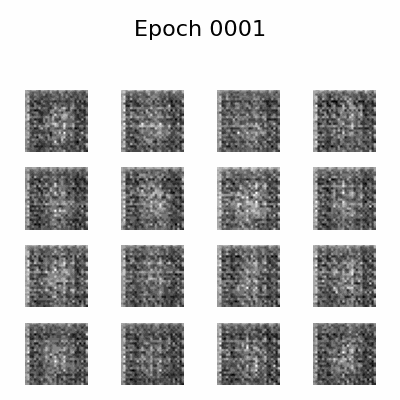

In [26]:
try:
    display(Image(open(anim_file, 'rb').read()))
except NameError:
    # If not in Jupyter/Colab, this will fail. User can open the GIF file manually.
    print("GIF display requires IPython.display.Image, likely not in a notebook environment.")